# zad1 Jakub Iliński

In [212]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import List, Tuple, Callable, Dict
import torch
import numpy as np
from torch.nn import functional as F

PAPUGA = 'flax-community/papuGaPT2'
DEVICE = "cuda"

tokenizer = AutoTokenizer.from_pretrained(PAPUGA)
model = AutoModelForCausalLM.from_pretrained(PAPUGA).to(DEVICE)
model.device

device(type='cuda', index=0)

In [213]:
easy_md: List[Tuple[str, float]] = [
    ("1 + 1", 2),
    ("10 / 2", 5),
    ("\\frac{1}{2} + \\frac{1}{2}", 1),
    ("5 \\mod 2", 1),
    ("8 + 17", 25),
    ("14 - 15", -1),
    ("4 * 5", 20), 
    ("30 / 3", 10)
]

medium_md: List[Tuple[str, float]] = [
    ("1 - (-1)", 2),
    ("1 + (-1)", 0),
    ("4 \\times 5", 20), 
    ("1 + \\frac{1}{2}", 1.5),
    ("\\sqrt{4}", 2),
    ("3^3", 27),
    ("\\sum_{i = 1}^{10} 1", 10),
    ("\\pi / \\pi", 1),
]

easy_rpn: List[Tuple[str, float]] = [
    ("1 1 +", 2),
    ("10 2 /", 5),
    ("1 2 / 1 2 / +", 1),
    ("5 2 mod", 1),
    ("8 17 +", 25),
    ("14 15 -", -1),
    ("4 5 *", 20),
    ("30 3 /", 10)
]

medium_rpn: List[Tuple[str, float]] = [
    ("1 -1 -", 2),
    ("1 -1 +", 0),
    ("4 5 *", 20),
    ("1 1 2 / +", 1.5),
    ("4 sqrt", 2),
    ("3 3 ^", 27),
    ("1 1 1 1 1 1 1 1 1 1 + + + + + + + + +", 10),
    ("pi pi /", 1)
]

easy_natural: List[Tuple[str, float]] = [
    ("jeden dodać jeden", 2),
    ("dziesięć podzielić przez dwa", 5),
    ("jedna druga dodać jedna druga", 1),
    ("pięć modulo dwa", 1),
    ("osiem dodać siedemnaście", 25),
    ("czternaście odjąć piętnaście", -1),
    ("cztery razy pięć", 20),
    ("trzydzieści podzielić przez trzy", 10)
]

medium_natural: List[Tuple[str, float]] = [
    ("jeden odjąć minus jeden", 2),
    ("jeden dodać minus jeden", 0),
    ("cztery razy pięć", 20),
    ("jeden dodać jedna druga", 1.5),
    ("pierwiastek z czterech", 2),
    ("trzy do potęgi trzeciej", 27),
    ("suma dziesięciu jedynek", 10),
    ("pi podzielić przez pi", 1)
]

In [214]:
train_md: List[Tuple[str, float]] = [
    ("7 - 3", 4),
    ("6 * 3", 18),
    ("9 / 3", 3),
    ("5 + 10", 15),
    ("2^4", 16)
]

train_rpn: List[Tuple[str, float]] = [
    ("7 3 -", 4),
    ("6 3 *", 18),
    ("9 3 /", 3),
    ("5 10 +", 15),
    ("2 4 ^", 16)
]

train_natural: List[Tuple[str, float]] = [
    ("siedem odjąć trzy", 4),
    ("sześć razy trzy", 18),
    ("dziewięć podzielić przez trzy", 3),
    ("pięć dodać dziesięć", 15),
    ("dwa do potęgi czwartej", 16)
]

In [215]:
def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

def get_prob(context: str, label: str) -> float:
    full = context + label
    
    input_ids_full = tokenizer(full, return_tensors='pt')['input_ids'].to(DEVICE)
    input_ids_context = tokenizer(context, return_tensors='pt')['input_ids'].to(DEVICE)
    
    with torch.no_grad():
        output = model(input_ids=input_ids_full)
        logits, labels = output.logits[:, :-1, :], input_ids_full[:, 1:]
        log_probs = log_probs_from_logits(logits, labels)
        
    context_len, full_len = input_ids_context.size(1), input_ids_full.size(1)
    start, end = max(context_len - 1, 0), full_len - 1
    
    label_log_probs = log_probs[:, start:end]
    return float(label_log_probs.mean().item())

def generate_candidates(prompt: str, num: int, max_new_tokens: int) -> List[str]:
    input_ids = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    
    out = model.generate(
        **input_ids,
        no_repeat_ngram_size=3,
        temperature=0.9,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        num_return_sequences=num,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )
    
    texts: List[str] = []
    for seq in out:
        full = tokenizer.decode(seq, skip_special_tokens=True)
        new = full[len(prompt):]
        texts.append(new.strip())
        
    return texts

def pick_best_candidate(candidates: List[str]) -> str:
    ans: List[Tuple[int, str]] = []
    for candidate in candidates:
        score = 0
        for char in candidate:
            if not ord('0') <= ord(char) <= ord('9'):
                score -= 1
        ans.append((score, candidate))
        
    return sorted(ans, reverse=True)[0][1]

In [216]:
def template1(question: str, ans: float | None = None) -> str:
    prompt = f"{question} = "
    if ans:
        prompt += f"{ans}"
        
    return prompt
        
def template2(question: str, ans: float | None = None) -> str:
    prompt = f"{question} po uproszczeniu to "
    if ans:
        prompt += f"{ans}"
        
    return prompt
    
    
def template3(question: str, ans: float | None = None) -> str:
    prompt = f"wyrażenie {question} jest równe "
    if ans:
        prompt += f"{ans}"
        
    return prompt
    
    
def template4(question: str, ans: float | None = None) -> str:
    prompt = f"wynikiem {question} jest "
    if ans:
        prompt += f"{ans}"
        
    return prompt

In [217]:
def diff(chat_ans: str, true_ans: float) -> float:
    try:
        return min(abs(float(chat_ans) - true_ans), 100)
    except:
        return 100
    
def evaluate(template: Callable[[str, float | None], str],
            train: List[Tuple[str, float]],
            test: List[Tuple[str, float]],
            ) -> float:

    score: float = 0
    for (question, ans) in test: 
        prompt = " \n ".join([template(q, a) for (q, a) in train])
        prompt += " \n " + template(question)
        
        candidates = generate_candidates(prompt, 25, 3)
        
        print(candidates)
        print()
        
        score += diff(pick_best_candidate(candidates), ans)
    
    return score

In [218]:
from dataclasses import dataclass, asdict

@dataclass
class Score:
    template: str
    data_type: str
    score: float
    
data_map = {
    "easy_md": (easy_md, train_md),
    "medium_md": (medium_md, train_md),
    "easy_rpn": (easy_rpn, train_rpn),
    "medium_rpn": (medium_rpn, train_rpn),
    "easy_natural": (easy_natural, train_natural),
    "medium_natural": (medium_natural, train_natural),
}

template_map = {
    "template1": template1,
    "template2": template2,
    "template3": template3,
    "template4": template4,
}

scores: List[Score] = []
for t_name, t_fun in template_map.items():
    for d_name, (d_test, d_train) in data_map.items():
        scores.append(Score(t_name, d_name, evaluate(t_fun, d_train, d_test)))
scores

['* 7 =', '/ 3 <', '+ 1', 'Ɂ', '+', '~ 4*', '/ 2 *', '2', '+ 7 -', '/', '(0);', '>', '4', '\\\\ 1', '�', '+ 1', '≈', '*1 *', '^2 +', '5 * 4', '// 1', '4  .', '/ 4*', '+', '* 5 +']

['/ 1 =', '(2 )', '+ 1', '/ 4 =', '+', '3 + 5', '/5 =', '/ 3', '/ 2', '/ 5', '= 19', '(2 =', '3 C +', '/ (1', '4 = 1', '+  +', '/ 10 =', '*8 =', '5 + 7', '\\\\ / 1', '4 + 0', '/ 2 *', '/ 3 +', '/ 0', '/ 3 2']

['\\\\ 1}', '\\fra(', '\\\\  \\', '× x 2', '^{3', '\\\\ \\fra', '\\\\ \\fra', '\\frac', '\\\\ 8', '\\image{', '\\frax', '\\\\ {\\', '\\\\ 6 /', '\\\\ [3', '\\\\ * 3', '\\\\ {b', '\\\\ x2', '\\\\ \\fra', '\\frac', '\\\\ 0 \\', '\\\\ {\\', '\\cdot', '\\fracs', 'q \\ge', '\\fracea']

['\\\\ \\m', '/ 3', '^ 6 /', '\\\\ 5', '_ 3', '/1', '+  ^', '\\\\ 4 (', '5.2', '\\mod', '\\moid', '_{1', 'єp', '\\\\0+', '4  4', '\\\\ 2^', '\\\\ 1 ^', '\\\\ 2 =', 'ld ld', '◡', '\\mod', '× 3.', '∫', '\\modu', '\\\\ 3']

['3', '# 2 =', '10  10', '4 + 7', '9  /', '/ 3', '/ 2 ]', '+ 4 +', '/ / /', '+ 15 /', '* 15', '/', '/ 11 =

[Score(template='template1', data_type='easy_md', score=345.0),
 Score(template='template1', data_type='medium_md', score=625.0),
 Score(template='template1', data_type='easy_rpn', score=622.0),
 Score(template='template1', data_type='medium_rpn', score=611.0),
 Score(template='template1', data_type='easy_natural', score=505.0),
 Score(template='template1', data_type='medium_natural', score=153.5),
 Score(template='template2', data_type='easy_md', score=509.0),
 Score(template='template2', data_type='medium_md', score=432.5),
 Score(template='template2', data_type='easy_rpn', score=800),
 Score(template='template2', data_type='medium_rpn', score=700.0),
 Score(template='template2', data_type='easy_natural', score=349.0),
 Score(template='template2', data_type='medium_natural', score=165.5),
 Score(template='template3', data_type='easy_md', score=152.0),
 Score(template='template3', data_type='medium_md', score=162.5),
 Score(template='template3', data_type='easy_rpn', score=253.0),
 Sc

<Figure size 1200x600 with 0 Axes>

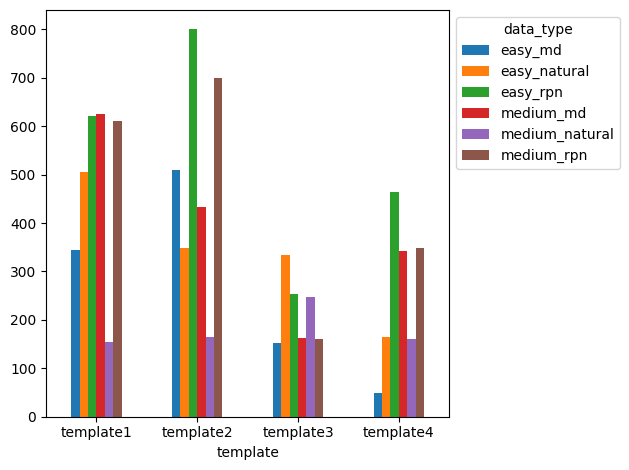

<Figure size 1200x600 with 0 Axes>

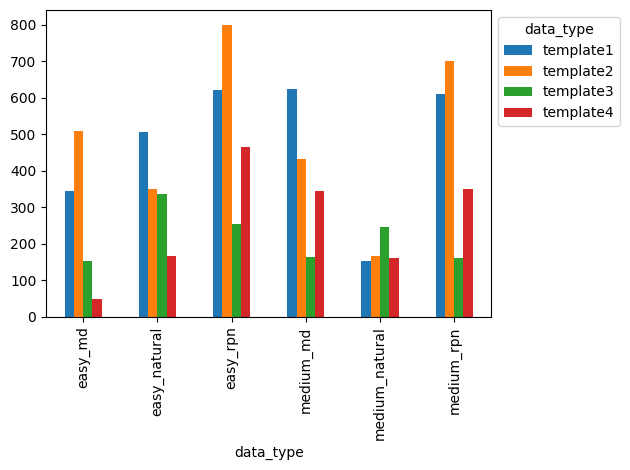

In [225]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame([asdict(s) for s in scores])

pivot = df.pivot(index="template", columns="data_type", values="score")
plt.figure(figsize=(12, 6))
ax = pivot.plot(kind="bar") 
plt.xticks(rotation=0)
plt.legend(title="data_type", bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()


pivot = df.pivot(index="data_type", columns="template", values="score")
plt.figure(figsize=(12, 6))
ax = pivot.plot(kind="bar") 
plt.legend(title="data_type", bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()